In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import beacon
from tqdm import tqdm
from torchinfo import summary

F:\projects\ResearchProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "mps"

In [3]:
def draw_parabola(canvas, origin=None):
    if origin is None:
        origin_x = np.random.randint(0, canvas.shape[1])
        origin_y = np.random.randint(canvas.shape[0]*0.25, canvas.shape[0])
    else:
        origin_x = origin[0]
        origin_y = origin[1]

    theta = np.arange(0, 1*np.pi, 0.0001)

    min_side = np.minimum(canvas.shape[1], canvas.shape[0])
    radius = np.random.randint(min_side, min_side*3)
    x = origin_x + radius * np.cos(theta)
    y = (origin_y - radius + 1) + radius * np.sin(theta)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)

    valid_indices = np.where((x >= 0) & (x < canvas.shape[1]) & (y >= 0) & (y < canvas.shape[0]))

    x_parabola_coords = x[valid_indices]
    y_parabola_coords = y[valid_indices]
    canvas[y_parabola_coords, x_parabola_coords] = 1

    point_r = (x_parabola_coords[0], y_parabola_coords[0])
    point_l = (x_parabola_coords[-1], y_parabola_coords[-1])

    return point_r, point_l


def draw_line(canvas, start, angle, max_lit_px=400):
    angle = np.radians(angle)

    dx = np.cos(angle)
    dy = np.sin(angle)

    x, y = start
    lit_pixels = 0

    while lit_pixels < max_lit_px:
        x_rounded = int(round(x))
        y_rounded = int(round(y))

        if 0 <= x_rounded < canvas.shape[1] and 0 <= y_rounded < canvas.shape[0]:
            canvas[y_rounded, x_rounded] = 1

        if lit_pixels != 0:
            if x_rounded <= 0:
                dx = abs(dx)
            elif x_rounded >= canvas.shape[1] - 1:
                dx = -abs(dx)

        x += dx
        y -= dy
        lit_pixels += 1


def random_remove_points(canvas, n_remove):
    none_zero_indices = canvas.nonzero()
    if none_zero_indices.shape[0] < n_remove:
        return

    if n_remove >= 1:
        random_indices = np.random.choice(none_zero_indices.shape[0], n_remove, replace=False)
    else:
        n = int(n_remove * none_zero_indices.shape[0])
        random_indices = np.random.choice(none_zero_indices.shape[0], n, replace=False)

    for i in random_indices:
        x = none_zero_indices[i][1]
        y = none_zero_indices[i][0]
        canvas[y, x] = 0



def set_continuous_time(canvas, t_start):
    rows, cols = canvas.shape
    canvas = canvas.clone()

    first_row = 0
    time_end = 0

    for row in range(rows-1, -1, -1):
        non_zero_indices = np.where(canvas[row, :] != 0)[0]
        if non_zero_indices.size > 0:
            if first_row is None:
                first_row = row
            time_index = rows - row + t_start
            canvas[row, non_zero_indices] = time_index
            time_end = time_index

    return canvas, time_end


def set_random_time(canvas, t_start, t_end):
    # Clone the canvas to avoid modifying the original
    canvas = canvas.clone()

    # Generate random integers for all positions with the same dtype as canvas
    random_times = torch.randint(t_start, t_end, canvas.shape, dtype=canvas.dtype, device=canvas.device)

    # Update non-zero elements of the canvas with the random times
    canvas[canvas != 0] = random_times[canvas != 0]

    return canvas


def generate_binary_noise(*dim, p=0.001, magnitude=1):
    random_tensor = torch.rand(*dim)
    return (random_tensor < p).float() * magnitude

def generate_noise(data, p=0.001):
    return torch.clamp(generate_binary_noise(data.shape, p=p, magnitude=1) - data, 0, 1)


def plot3d(data, ax=None):
    if ax is None:
        ax = plt.figure().add_subplot(projection='3d')
    data_np = data.numpy().squeeze()
    y, x = np.nonzero(data_np)
    time_values = data_np[y, x]
    ax.scatter(y, x, time_values, c=time_values)
    ax.set_xlabel('Y')
    ax.set_ylabel('X')
    ax.set_zlabel('Time')
    ax.set_box_aspect(None, zoom=0.85)

def plot2d(data):
    plt.imshow(data.squeeze())
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar()

In [4]:
class TorchData:
    def __init__(self, t_dim, x_dim, y_dim, n_remove=10):
        """
        Initiate torch datasets.
        Args:
            t_dim: int, time dimension
            x_dim: int, x dimension
            y_dim: int, y dimension
            n_remove: int, number of points to remove
        """
        self.t_dim = t_dim
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.n_remove = n_remove
        self.signal = torch.zeros(self.x_dim, self.y_dim)
        self.noise = torch.zeros(self.x_dim, self.y_dim)
        self.sn = torch.zeros(self.x_dim, self.y_dim)
        self.signal_time = torch.zeros(self.x_dim, self.y_dim)
        self.noise_time = torch.zeros(self.x_dim, self.y_dim)
        self.sn_time = torch.zeros(self.x_dim, self.y_dim)
        self.generate()

    def generate(self):
        """
        Generate datasets.
        """
        pr, pl = draw_parabola(self.signal)

        angle = np.random.randint(10, 40)
        draw_line(self.signal, pr, angle)
        draw_line(self.signal, pl, angle)
        random_remove_points(self.signal, self.n_remove)
        self.signal_time, time_end = set_continuous_time(self.signal, 100)
        self.noise = generate_noise(self.signal, p=0.1)
        self.noise_time = set_random_time(self.noise, 100, time_end+10)
        self.sn = self.signal + self.noise
        self.sn_time = self.signal_time + self.noise_time


In [5]:
train_dataset = np.array([TorchData(100, 120, 92, 50) for _ in range(300)])
test_dataset = np.array([TorchData(100, 120, 92, 50) for _ in range(1)])

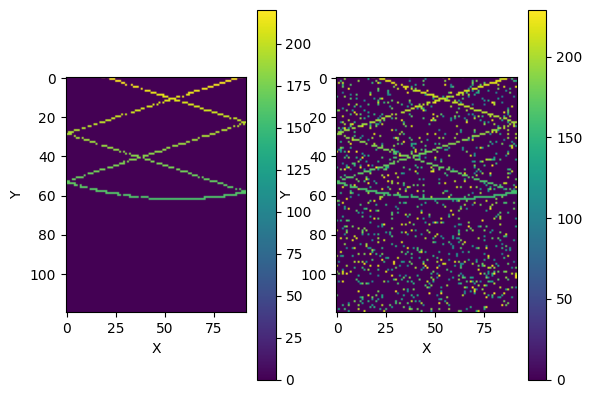

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
plot2d(train_dataset[0].signal_time)
ax2 = fig.add_subplot(122)
plot2d(train_dataset[0].sn_time)

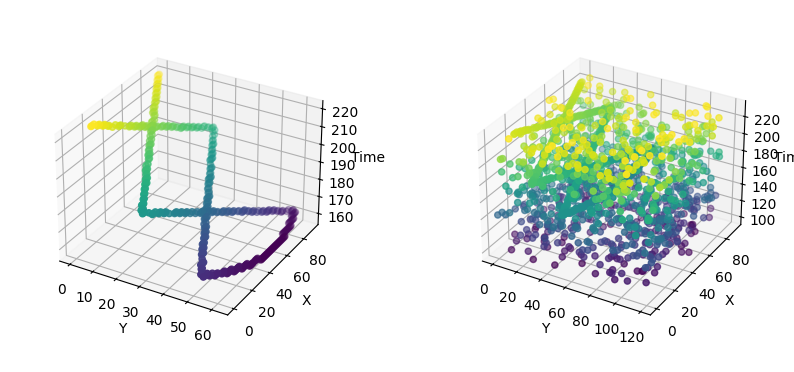

In [7]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection='3d')
plot3d(train_dataset[0].signal_time, ax1)
ax2 = fig.add_subplot(122, projection='3d')
plot3d(train_dataset[0].sn_time, ax2)

In [8]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(2, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            #torch.nn.Flatten()
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 2, 3, stride=1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
summary(ConvolutionAutoencoder(), input_size=(300, 2, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [300, 2, 120, 92]         --
├─Sequential: 1-1                        [300, 8, 114, 86]         --
│    └─Conv2d: 2-1                       [300, 64, 118, 90]        1,216
│    └─BatchNorm2d: 2-2                  [300, 64, 118, 90]        128
│    └─ReLU: 2-3                         [300, 64, 118, 90]        --
│    └─Conv2d: 2-4                       [300, 16, 116, 88]        9,232
│    └─BatchNorm2d: 2-5                  [300, 16, 116, 88]        32
│    └─ReLU: 2-6                         [300, 16, 116, 88]        --
│    └─Conv2d: 2-7                       [300, 8, 114, 86]         1,160
│    └─BatchNorm2d: 2-8                  [300, 8, 114, 86]         16
│    └─ReLU: 2-9                         [300, 8, 114, 86]         --
├─Sequential: 1-2                        [300, 2, 120, 92]         --
│    └─BatchNorm2d: 2-10                 [300, 8, 114, 86]         16
│    

In [10]:
autoencoder = ConvolutionAutoencoder().to(device)
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [11]:
a = np.array([_.sn for _ in train_dataset])
b = np.array([_.sn_time for _ in train_dataset])

noised_data = torch.tensor(np.stack((a, b), axis=1))

a = np.array([_.signal for _ in train_dataset])
b = np.array([_.signal_time for _ in train_dataset])

data = torch.tensor(np.stack((a, b), axis=1))

In [13]:
for i in tqdm(range(3000)):
    optimiser.zero_grad()
    outputs = autoencoder(noised_data.to(device))
    loss = loss_function(outputs, data.to(device))
    loss.backward()
    optimiser.step()

100%|██████████| 3000/3000 [18:57<00:00,  2.64it/s]


In [14]:
a = np.array([_.sn for _ in test_dataset])
b = np.array([_.sn_time for _ in test_dataset])

test_data = torch.tensor(np.stack((a, b), axis=1))

In [15]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data.to("cpu"))
    pred = pred.squeeze()

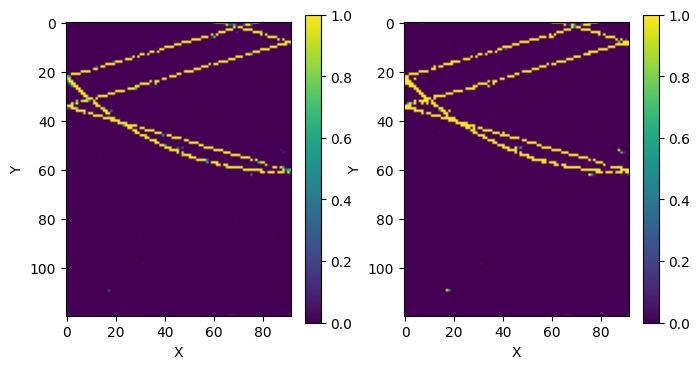

In [16]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
plot2d(pred[0])
ax2 = fig.add_subplot(122)
plot2d(pred[1])

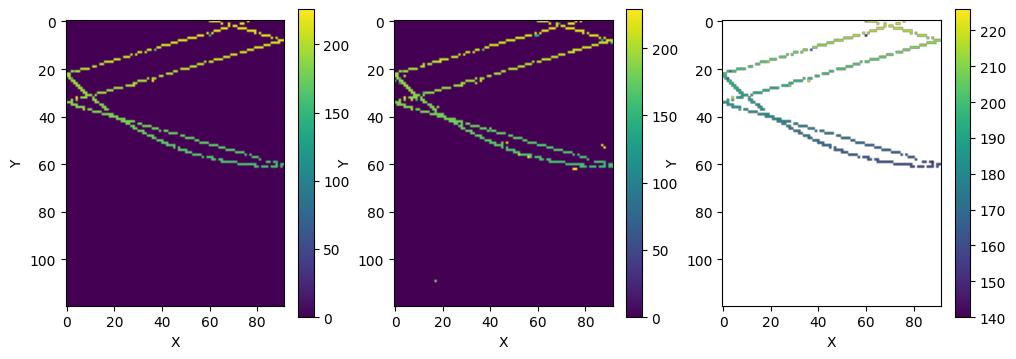

In [17]:
a = (pred[0] > 0.5).float() * test_dataset[0].sn_time
b = (pred[1] > 0.5).float() * test_dataset[0].sn_time
c = (b/ a) * test_dataset[0].sn_time
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
plot2d(a)
ax2 = fig.add_subplot(132)
plot2d(b)
ax3 = fig.add_subplot(133)
plot2d(c)

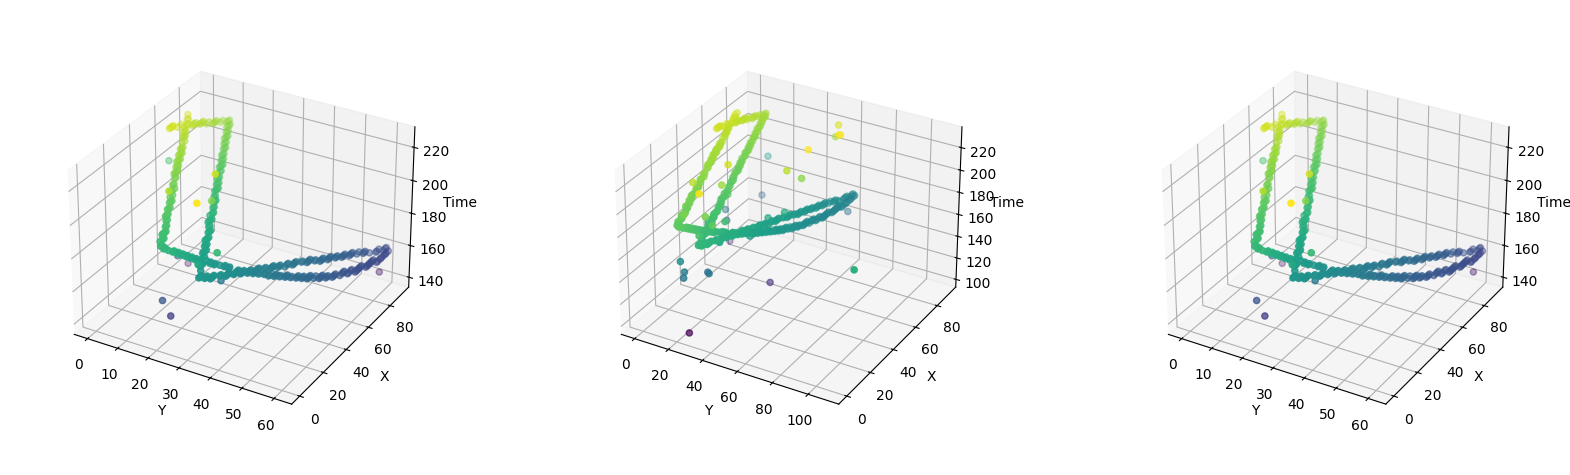

In [18]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(131, projection='3d')
plot3d(a, ax1)
ax2 = fig.add_subplot(132, projection='3d')
plot3d(b, ax2)
ax3 = fig.add_subplot(133, projection='3d')
plot3d(c, ax3)

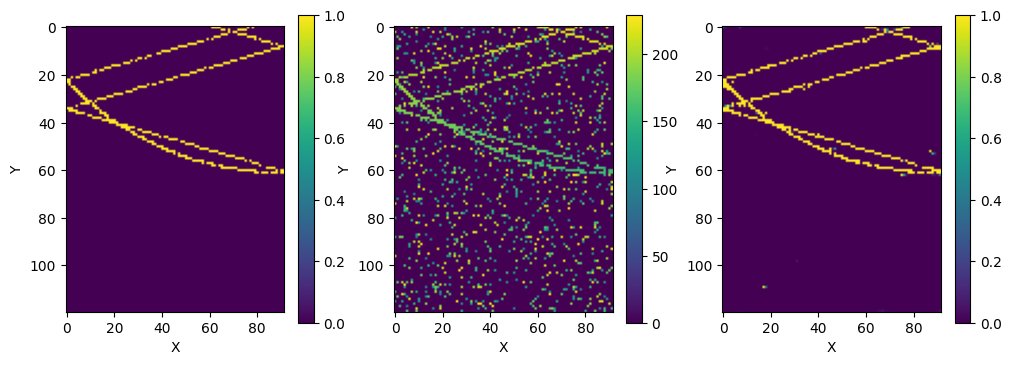

In [19]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
plot2d(test_dataset[0].signal)
ax2 = fig.add_subplot(132)
plot2d(test_dataset[0].sn_time)
ax3 = fig.add_subplot(133)
plot2d(pred[1])

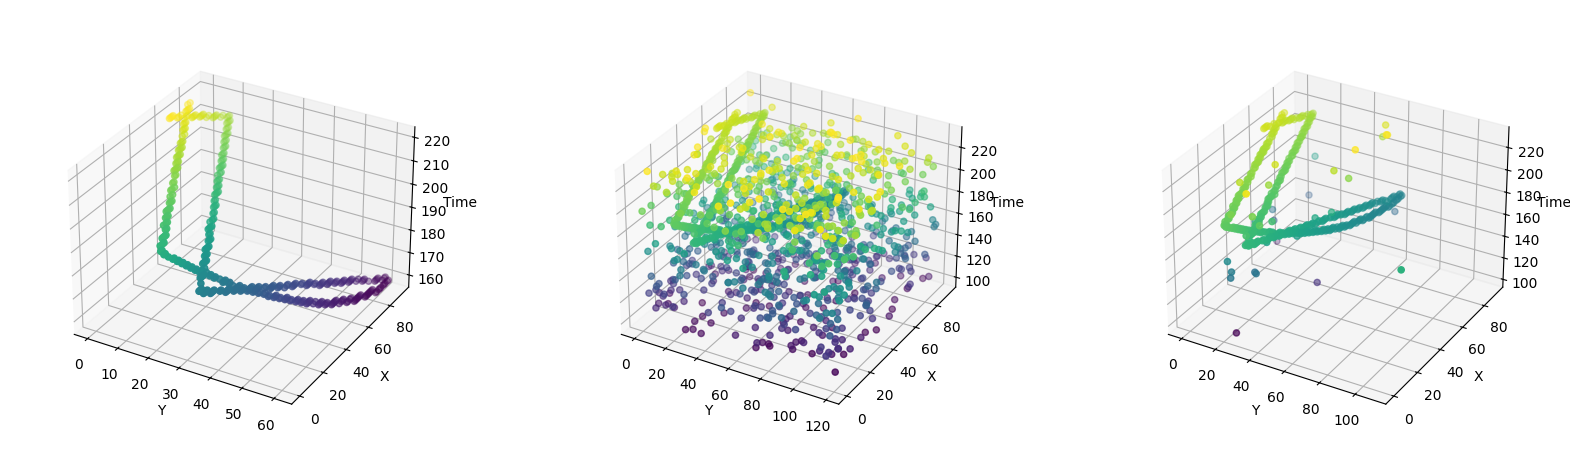

In [20]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(131, projection='3d')
plot3d(test_dataset[0].signal_time, ax1)
ax2 = fig.add_subplot(132, projection='3d')
plot3d(test_dataset[0].sn_time, ax2)
ax3 = fig.add_subplot(133, projection='3d')
plot3d(b, ax3)